# Klassifikation tabularer Daten

## Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

Wir betrachten den bekannten ["Adult"-Datensatz](https://archive.ics.uci.edu/ml/datasets/Adult), welcher Zensusdaten zum Einkommen von Personen aus dem Jahr 1994 enthält. Die Aufgabe ist die korrekte Vorhersage, ob eine Person mehr oder weniger als 50.000 USD im Jahr verdient.

In [30]:
cols = ['age','workclass','fnlwgt','education','education-num','marital_status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']

In [31]:
df = pd.read_csv('./data/tabular_data/adult.data', names=cols)

In [32]:
df.drop(['fnlwgt','education-num'],axis=1,inplace=True)

In [33]:
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital_status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital-gain    32561 non-null  int64 
 9   capital-loss    32561 non-null  int64 
 10  hours-per-week  32561 non-null  int64 
 11  native-country  32561 non-null  object
 12  income          32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


Encoding der Klasse $\mathbf{y}$ und Erstellung der *Merkmalsmatrix* $\mathbf{X}$:

In [35]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['income'])

In [36]:
y = df['label_encoded']
X = df.drop(['income','label_encoded'], axis=1)

Aufteilung der Daten in **Trainings-** und **Testdaten**:

In [37]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.15,
                     stratify = y,
                     random_state=1)

## Modeling

In [38]:
ct = make_column_transformer(
     (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan), make_column_selector(dtype_include=[object,bool])),
     remainder='passthrough')

In [39]:
pipe_rf = make_pipeline(ct,
                        RandomForestClassifier(random_state=1)
                       )

In [41]:
rf_cls = pipe_rf.fit(X_train,y_train)

## Evaluation

In [42]:
y_pred = rf_cls.predict(X_test)

In [43]:
print(f'Genauigkeit auf den Trainingsdaten: {rf_cls.score(X_train,y_train):.2%}')

Genauigkeit auf den Trainingsdaten: 97.80%


In [44]:
print(f'Genauigkeit auf den Testdaten: {rf_cls.score(X_test,y_test):.2%}')

Genauigkeit auf den Testdaten: 84.69%


In [45]:
print(f'Null-Accuracy: {y_test.value_counts().iloc[0]/sum(y_test.value_counts()):.2%}')

Null-Accuracy: 75.93%


In [46]:
%matplotlib inline

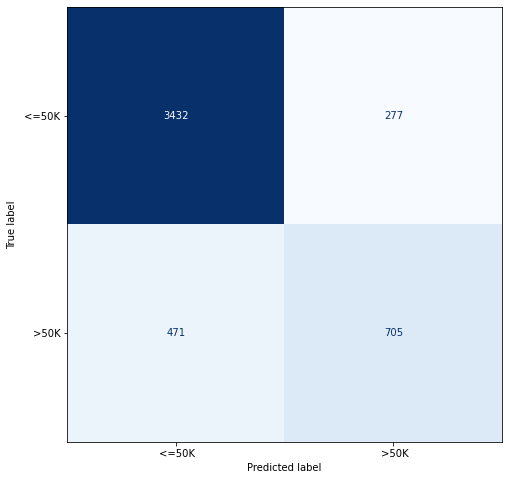

In [47]:
fig,ax = plt.subplots(figsize=(8,8))
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cmp.plot(ax=ax,cmap='Blues',colorbar=False);

### Feature Importance - wie wichtig sind die Merkmale für die Vorhersage des Modells?

In [50]:
fi = rf_cls.get_params()['randomforestclassifier'].feature_importances_
fi_list = sorted(list(zip(X_train.columns.values, fi)), key=lambda tup: tup[1], reverse=True)

In [51]:
for fi in fi_list:
    print(f'{fi[0]} - {fi[1]:.2%}')

capital-gain - 22.04%
capital-loss - 13.44%
occupation - 11.45%
native-country - 11.07%
workclass - 10.30%
marital_status - 9.43%
education - 7.32%
age - 5.18%
hours-per-week - 4.55%
sex - 2.16%
relationship - 1.84%
race - 1.22%
